In [1]:
import os
import yaml
import torch
from easydict import EasyDict
from interfaces.super_resolution import TextSR
from model.tsrn import TSRN
import argparse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device = torch.device("cpu")

args = argparse.Namespace()

args.arch = 'tsrn_tl_cascade'
args.use_distill =True
args.sr_share = True 
args.stu_iter = 1
args.syn = False
args.mixed = False
args.mask = True
args.STN = True
args.random_reso = False
args.ic15sr = False
args.gradient = True
args.srb = 5
args.hd_u = 32
args.resume = 'ckpt/model_best_0.pth'
# args.resume = 'ckpt/checkpoint.pth'
args.batch_size = 2
args.test_data_dir = ''
args.vis_dir = ''

config_path = os.path.join('config', 'super_resolution.yaml')
config = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)
config = EasyDict(config)
tsr = TextSR(config=config, args=args)

model = tsr.generator_init()['model']
model = model.to(device)
model.eval()

loading pre-trained model from ckpt/model_best_0.pth 


TSRN_TL(
  (block1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): RecurrentResidualBlockTL(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gru1): GruBlock(
      (conv1): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
      (gru): GRU(64, 32, batch_first=True, bidirectional=True)
    )
    (prelu): mish()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gru2): GruBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (gru): GRU(64, 32, batch_first=True, bidirectional=True)
    )
  )
  (block3): RecurrentResidualBlockTL(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64

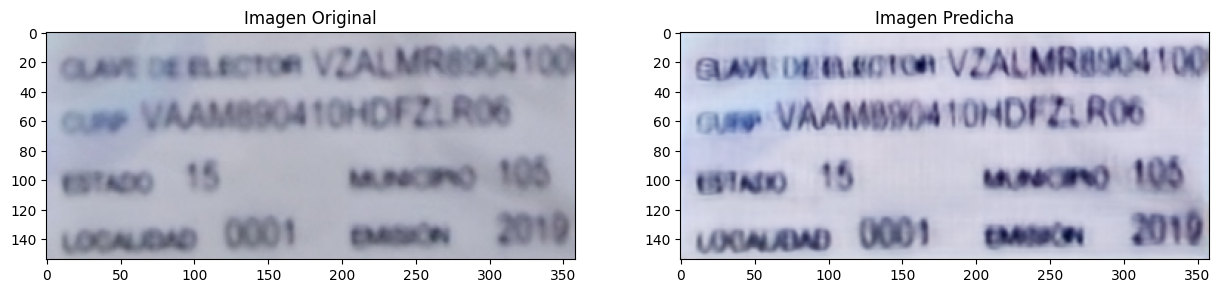

In [11]:
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

class resizeNormalize(object):
    def __init__(self, size, mask=False, interpolation=Image.BICUBIC):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()
        self.mask = mask

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img_tensor = self.toTensor(img)
        if self.mask:
            mask = img.convert('L')
            thres = np.array(mask).mean()
            mask = mask.point(lambda x: 0 if x > thres else 255)
            mask = self.toTensor(mask)
            img_tensor = torch.cat((img_tensor, mask), 0)
        return img_tensor

img_path = '/Users/jorgecamero/MoireDataset/test/0b0f5f50-ef0c-470b-aac3-2ecebdb72a47_front.jpg'
image = Image.open(img_path).convert("RGB")
transform = resizeNormalize(size=(224, 128), mask=True)
input_tensor = transform(image).to(device).unsqueeze(0)

output = model(input_tensor)[0][:3, :, :]
output_np = output.cpu().detach().numpy()
output_np = np.transpose(output_np, (1, 2, 0))
output_np = (output_np - output_np.min()) / (output_np.max() - output_np.min())
output_np = (output_np * 255).astype(np.uint8)
output_image = Image.fromarray(output_np)
output_image = output_image.resize((image.size[0], image.size[1]))

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Imagen Original")
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Imagen Predicha")
plt.axis('on')

plt.show()

In [10]:
import cv2

bgr_image = cv2.cvtColor(output_np, cv2.COLOR_RGB2BGR)
new_size = (image.size[0], image.size[1])
resized_image = cv2.resize(bgr_image, new_size, interpolation=cv2.INTER_LINEAR)

cv2.imwrite('/Users/jorgecamero/MoireDataset/test/0b0f5f50-ef0c-470b-aac3-2ecebdb72a47_front_processed_2.jpg', resized_image)

True